In [1]:
import torch
from Feature import feature
from Utils import recall, recall2, recall2_batch
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from Reader import ImageReader
from Utils import tra_transforms, eva_transforms
from color_lib import RGBmean, RGBstdv

In [2]:
Data = "HAR"
imgsize = 160
tra_transform = tra_transforms(imgsize, RGBmean[Data], RGBstdv[Data])
eva_transform = eva_transforms(imgsize, RGBmean[Data], RGBstdv[Data])

In [4]:
dsets_dict = torch.load("/notebooks/Image_Retrieval/EasyPositiveHardNegative-master/data_dict_emb_test.pth")
# dsets_dict = {p: ImageReader(data_dict[p], eva_transform) for p in phase}
model = models.resnet50(pretrained=True)
print('Setting model: resnet50')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 64)
checkpoint = torch.load("/notebooks/Image_Retrieval/EasyPositiveHardNegative-master/_result/EPHN/HAR_R50/G16_lr0.03/model_state_dict_R5050.pth")
model.load_state_dict(checkpoint)


Setting model: resnet50


<All keys matched successfully>

In [5]:
# model.load_state_dict(checkpoint)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
dsets = ImageReader(dsets_dict['gallery'], tra_transform)
dsets1 = ImageReader(dsets_dict['query'], tra_transform)

In [7]:
dsets.classes

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

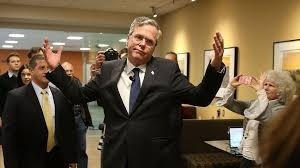

In [40]:
from PIL import Image
im = Image.open(dsets1.imgs[15][0])  
im

15th query ka example zroor dena


In [8]:
class_names = dsets1.class_to_idx
(class_names)
inv_map = {v: k for k, v in class_names.items()}
inv_map

{0: 'calling',
 1: 'clapping',
 2: 'cycling',
 3: 'dancing',
 4: 'drinking',
 5: 'eating',
 6: 'fighting',
 7: 'hugging',
 8: 'laughing',
 9: 'listening_to_music',
 10: 'running',
 11: 'sitting',
 12: 'sleeping',
 13: 'texting',
 14: 'using_laptop'}

In [11]:
 get_class_name_from_id(dsets1.imgs[125][1],inv_map)

'sleeping'

In [10]:
def get_class_name_from_id(class_id_of_image,class_name_dict):
    class_name = class_name_dict[class_id_of_image]
    return class_name
class_name = get_class_name_from_id(0,inv_map)
class_name    

'calling'

In [155]:
idx[55]

tensor([787, 961, 981, 943, 973, 964, 950, 998, 991, 956, 633, 984, 972, 952,
        994, 942, 963, 966, 977,  64, 976, 933, 939,  49, 947, 990, 982,   6,
        900, 967, 948, 957, 959, 968, 983, 962,  22, 931, 954, 946,  10, 999,
        945, 761, 971, 974, 997,  32, 809, 955])

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
candidates_idxx = [787, 961, 981, 943, 973, 964, 950, 998, 991, 956, 633, 984, 972, 952,
        994, 942, 963, 966, 977,  64, 976, 933, 939,  49, 947, 990, 982,   6,
        900, 967, 948, 957, 959, 968, 983, 962,  22, 931, 954, 946,  10, 999,
        945, 761, 971, 974, 997,  32, 809, 955]
columns = 3
plt.figure(figsize=(100,100))
query_image = dsets1.imgs[55][0]
image = Image.open(query_image)
image = np.asarray(image)
ax = plt.subplot(50, columns, 1)
ax.set_title(f"Query: {query_image.split('/')[-1]}")
plt.imshow(image)
for i, idxx in enumerate(candidates_idxx):
    image_path = dsets.imgs[idxx][0]
    image = Image.open(image_path)
    image = np.asarray(image)
    ax = plt.subplot(50, columns, i  + 1 + 5)
    ax.set_title(image_path.split("/")[-1])
    plt.imshow(image)

In [13]:
Fvec_val = feature(dsets1, model)
Fvec_gal = feature(dsets, model)
imgLab_val = dsets1.idx_to_class
imgLab_gal = dsets.idx_to_class

In [45]:
Fvec_val.shape

torch.Size([150, 64])

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


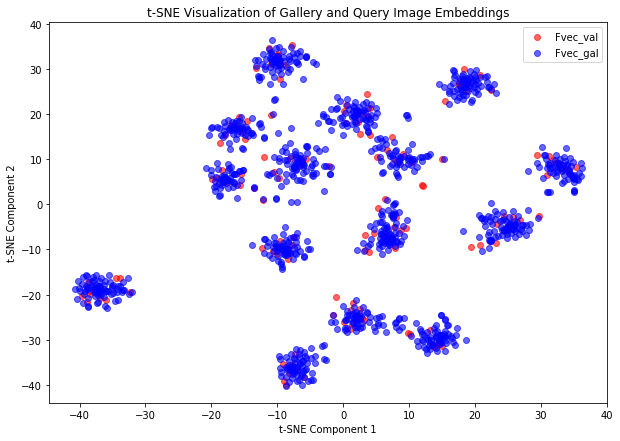

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming Fvec_val and Fvec_gal are already defined
# Example data (replace these with your actual data)
# Fvec_val = np.random.rand(150, 64)
# Fvec_gal = np.random.rand(1000, 64)

# Combine the embeddings
combined_embeddings = np.vstack((Fvec_val, Fvec_gal))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_embeddings)

# Split the results back into val and gal
tsne_val = tsne_results[:150]
tsne_gal = tsne_results[150:]

# Plot the results
plt.figure(figsize=(10, 7))

# Plot val embeddings
plt.scatter(tsne_val[:, 0], tsne_val[:, 1], c='red', label='Fvec_val', alpha=0.6)

# Plot gal embeddings
plt.scatter(tsne_gal[:, 0], tsne_gal[:, 1], c='blue', label='Fvec_gal', alpha=0.6)

plt.legend()
plt.title('t-SNE Visualization of Gallery and Query Image Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [49]:
dsets_dict_train= torch.load("/notebooks/Image_Retrieval/EasyPositiveHardNegative-master/data_dict_emb1.pth")
dsets_train = ImageReader(dsets_dict_train['tra'], tra_transform)
dsets_test = ImageReader(dsets_dict_train['test'], tra_transform)
Fvec_train = feature(dsets_train, model)
Fvec_test = feature(dsets_test, model)
train_set = dsets_train.idx_to_class
test_set = dsets_test.idx_to_class

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [52]:
Fvec_train.shape,Fvec_test.shape


(torch.Size([11443, 64]), torch.Size([1000, 64]))

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


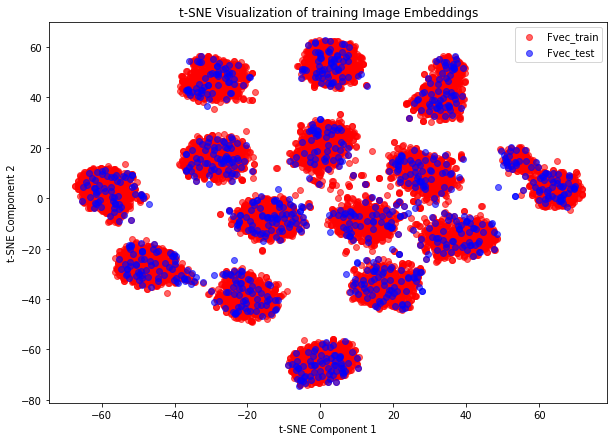

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE



# Combine the embeddings
combined_embeddings = np.vstack((Fvec_train, Fvec_test))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_embeddings)

# Split the results back into val and gal
tsne_train = tsne_results[:11443]
tsne_test = tsne_results[11443:]

# Plot the results
plt.figure(figsize=(10, 7))

# Plot val embeddings
plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c='red', label='Fvec_train', alpha=0.6)

# Plot gal embeddings
plt.scatter(tsne_test[:, 0], tsne_test[:, 1], c='blue', label='Fvec_test', alpha=0.6)

plt.legend()
plt.title('t-SNE Visualization of training Image Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## mAP@k=1

In [14]:
N = len(imgLab_val)
imgLab_val = torch.LongTensor([imgLab_val[i] for i in range(len(imgLab_val))])
imgLab_gal = torch.LongTensor([imgLab_gal[i] for i in range(len(imgLab_gal))])

In [15]:
D = Fvec_val.mm(torch.t(Fvec_gal))
preds_1 = []
_,idx = D.max(1)
imgPre = imgLab_gal[idx]
preds_1.append(imgPre)
A = (imgPre==imgLab_val).float()
recall_1 = (torch.sum(A)/N).item()


In [16]:
recall_1

0.7066666483879089

In [17]:
precision_1=[]
rank_1 = [0]*150
k=1
for i in range(150):
    relevant_count = 0
    precision_sum = 0
    for j in range(k):
        if((preds_1[j][i])==imgLab_val[i]):
            # print(preds1[i])
            if(rank_1[i]==0):
                rank_1[i] = (j+1)
            relevant_count += 1
            precision_sum += relevant_count / (j + 1)
            # print(precision_sum)
    ap = precision_sum / k
        # print(ap)
            
    precision_1.append(ap)

In [18]:
sum_precision_1 = sum(precision_1)

In [19]:
map_1 = sum_precision_1/N
map_1

0.7066666666666667

In [20]:
sum(rank_1)/150

0.7066666666666667

In [39]:
no_relevant_img_1=[]
for i in range(len(rank_1)):
    if rank_1[i] == 0:
        no_relevant_img_1.append(i)
len(no_relevant_img_1)

44

In [61]:
D


tensor([[ 0.0236, -0.1163, -0.2755,  ...,  0.4113,  0.5511,  0.2319],
        [ 0.0830,  0.3949,  0.0047,  ...,  0.1088,  0.0916,  0.1578],
        [ 0.3001, -0.0565,  0.2835,  ..., -0.1077, -0.1218,  0.1212],
        ...,
        [ 0.2729,  0.4691,  0.2628,  ...,  0.6230,  0.3767,  0.6189],
        [ 0.1831,  0.1627,  0.4251,  ...,  0.3030,  0.1257,  0.2952],
        [ 0.1420,  0.3169,  0.1142,  ...,  0.5709,  0.4008,  0.4919]])

In [52]:
D.shape

torch.Size([150, 1000])

### mAP @ K=10

In [22]:
rank=[10]

In [23]:
N = len(imgLab_val)
imgLab_val = torch.LongTensor([imgLab_val[i] for i in range(len(imgLab_val))])
imgLab_gal = torch.LongTensor([imgLab_gal[i] for i in range(len(imgLab_gal))])

D = Fvec_val.mm(torch.t(Fvec_gal))
_,idx = D.topk(rank[-1])
acc_list = []
preds_10 = []
for r in rank:
    A = 0
    for i in range(r):
        imgPre = imgLab_gal[idx[:,i]]
        preds_10.append(imgPre)
        A += (imgPre==imgLab_val).float()
    acc_list.append((torch.sum((A>0).float())/N).item())
recall_10=torch.Tensor(acc_list)

In [24]:
recall_10

tensor([0.8933])

In [25]:
precision_10=[]
rank_10 = [0]*150
k=10
for i in range(N):
    relevant_count = 0
    precision_sum = 0
    for j in range(k):
        if((preds_10[j][i])==imgLab_val[i]):
            # print(preds1[i])
            if(rank_10[i]==0):
                rank_10[i] = (j+1)
            relevant_count += 1
            precision_sum += relevant_count / (j + 1)
            # print(precision_sum)
    ap = precision_sum / k
        # print(ap)
            
    precision_10.append(ap)
    

In [26]:
sum_precision_10 = sum(precision_10)

In [27]:
map_10 = sum_precision_10/N
map_10

0.6786767195767195

In [28]:
sum(rank_10)/N

1.4

In [29]:
no_relevant_img_10=[]
for i in range(len(rank_10)):
    if rank_10[i] == 0:
        no_relevant_img_10.append(i)
no_relevant_img_10

[0, 16, 40, 45, 50, 55, 66, 68, 92, 93, 95, 114, 125, 130, 131, 139]

## mAP@k=50

In [30]:
rank=[50]

In [31]:
N = len(imgLab_val)
imgLab_val = torch.LongTensor([imgLab_val[i] for i in range(len(imgLab_val))])
imgLab_gal = torch.LongTensor([imgLab_gal[i] for i in range(len(imgLab_gal))])

D = Fvec_val.mm(torch.t(Fvec_gal))
_,idx = D.topk(rank[-1])
acc_list = []
preds_50 = []
for r in rank:
    A = 0
    for i in range(r):
        imgPre = imgLab_gal[idx[:,i]]
        preds_50.append(imgPre)
        A += (imgPre==imgLab_val).float()
    acc_list.append((torch.sum((A>0).float())/N).item())
recall_50=torch.Tensor(acc_list)

In [32]:
recall_50

tensor([0.9800])

In [33]:
precision_50=[]
rank_50 = [0]*150
k=50
for i in range(N):
    relevant_count = 0
    precision_sum = 0
    for j in range(k):
        if((preds_50[j][i])==imgLab_val[i]):
            # print(preds1[i])
            if(rank_50[i]==0):
                rank_50[i] = (j+1)
            relevant_count += 1
            precision_sum += relevant_count / (j + 1)
            # print(precision_sum)
    ap = precision_sum / k
        # print(ap)
            
    precision_50.append(ap)

In [34]:
sum_precision_50 = sum(precision_50)

In [35]:
map_50 = sum_precision_50/N
map_50

0.5758466592660508

In [36]:
sum(rank_50)/N

3.8733333333333335

In [37]:
no_relevant_img_50=[]
for i in range(len(rank_50)):
    if rank_50[i] == 0:
        no_relevant_img_50.append(i)
no_relevant_img_50

[0, 50, 125]

## Get mean and std

In [10]:
import os
import torchvision

In [4]:
os.listdir("/notebooks/Image_Retrieval/Hierarchy-image-retrieval-main/dataset/train_data")

['sleeping',
 'clapping',
 'laughing',
 'listening_to_music',
 'dancing',
 'calling',
 'sitting',
 'hugging',
 'using_laptop',
 'running',
 'eating',
 'texting',
 'cycling',
 'fighting',
 'drinking']

In [5]:
training_dataset_path = "/notebooks/Image_Retrieval/Hierarchy-image-retrieval-main/dataset/train_data"

In [8]:
training_transforms = transforms.Compose([transforms.Resize((160,160)),transforms.ToTensor()])

In [13]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path,transform=training_transforms)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=128,shuffle=False)

In [23]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images,_ in loader:
        images_count_in_a_batch = images.size(0)
        images = images.view(images_count_in_a_batch,images.size(1),-1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images_count_in_a_batch
    
    mean /= total_images_count
    std /= total_images_count
    return mean,std
    

In [24]:
get_mean_and_std(train_loader)

(tensor([0.5717, 0.5368, 0.5057]), tensor([0.2396, 0.2372, 0.2406]))